# This notebook is for developing plotting functions

In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from obspy import Stream,UTCDateTime
from pnwstore.mseed import WaveformClient
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from obspy.geodetics import locations2degrees, degrees2kilometers
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from obspy.clients.fdsn import Client as FDSNClient




In [2]:
def subplots_cluster_scale_rand(mycatalog, mycatalog_picks, networks, channel, fig_title, file_title):
    """
    mycatalog: dataframe that contains only the unique events (e.g., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    networks: csv file listing at least the networks of stations that picked the events in mycatalog (e.g., pd.read_csv('../data/networks/networks.csv))
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    fig_title: title in a string
    file_title: file title in a string
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')

    # Plot the earthquake moveout for one of the unmatched events for all stations 
    events = mycatalog
    picks = mycatalog_picks
    events['datetime'] = pd.to_datetime(events['time'], utc=True)
    networks = ','.join(list(networks['networks']))
    p = PdfPages(file_title) 
    
    # Randomly select 5 events
    random_events = events.sample(n=3)
    # random_events = events.sample(n=3,random_state=44)

    for time in tqdm(random_events['time'], total=len(random_events['time'])):

        idx = random_events.loc[random_events['datetime'] == time, 'idx'].values[0]
        # print('idx:', idx)
        picks_idx = picks.loc[picks['time'] == time]
        pick_sta = np.unique(picks_idx['station'])

        otime = UTCDateTime(str(random_events[random_events['idx'] == idx]["datetime"].values[0]))
        distances = []
        

        for station in pick_sta:
            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8, level="response")
            if len(sta_inv) == 0:
                continue
            
            _network = sta_inv[0].code
            slat = sta_inv[0][0].latitude
            slon = sta_inv[0][0].longitude
            olat = events.loc[events['idx']==idx, 'latitude'].values[0]
            olon = events.loc[events['idx']==idx, 'longitude'].values[0]

            dis1 = locations2degrees(olat, olon, slat, slon)
            dist = degrees2kilometers(dis1)

            distances.append([None, _network, station, dist])

        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])
        # print(distances)
        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        min_y_count = 0 

        max_x = 0
        min_x = 0
        min_x_count= 0

        # Create a figure
        fig, axs = plt.subplots(1, 4, figsize=(18, 6))
        gs = fig.add_gridspec(3, hspace=0, figure=fig)
        starttime = otime - 30
        endtime = otime + 120
        # Define texts
        texts = []
        # print('starttime:', starttime)
        # print('endtime:', endtime)
        for i, ii in enumerate(distances):
            # print('Network:', ii[1])
            # print('Station:', ii[2])
            if ii[2] == 'KBO':
                continue
            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            if len(s_picks) > 0:
                if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
            elif len(p_picks) > 0:
                if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            if len(p_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
            elif len(s_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

            if min_y_count == 0:
                if min_y < ii[3]:
                    min_y = ii[3] - 5
                    min_y_count += 1           
            else:
                if min_y >= ii[3]:
                    min_y = ii[3] - 5 

            max_y = ii[3] + 5

        scaling_factor = (1/2) * (max_y - min_y)

        chs = []  # Initialize chs here
        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel, starttime=starttime, endtime=endtime)
            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel, starttime=starttime, endtime=endtime)
            else: 
                st = Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

            if len(st) == 0:
                continue

            _st = Stream()
            has_HH = bool(st.select(channel="HH?"))
            has_BH = bool(st.select(channel="BH?"))

            if has_HH and has_BH:
                _st += st.select(channel="HH?")
            elif has_HH:
                _st += st.select(channel="HH?")
            elif has_BH:
                _st += st.select(channel="BH?")

            st = _st

            st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
            st.taper(max_percentage=0.05)
            st.filter(type='bandpass', freqmin=2, freqmax=25)
            st.merge(fill_value='interpolate')

            unique_channels = set(tr.stats.channel for tr in st)
            selected_traces = []

            for ch in unique_channels:
                selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
            st = Stream(selected_traces)

            trim_st = st.copy()
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']

            # Define the desired order of channels
            desired_order = {
                'Z': ['HHZ', 'BHZ'],
                'N': ['HHN', 'HH1', 'BHN', 'BH1'],
                'E': ['HHE', 'HH2', 'BHE', 'BH2']
            }

            # Function to map channels to their desired order
            def get_channel_priority(channel):
                for priority, (key, values) in enumerate(desired_order.items()):
                    if channel in values:
                        return priority
                return float('inf')  # Return a high value for channels not in the desired order

            # Sort the traces in trim_st based on the desired order
            trim_st = sorted(trim_st, key=lambda trace: get_channel_priority(trace.stats.channel))
            
            trim_st = Stream(trim_st)
            
            # print(trim_st)

            # plt.figure()
            # trim_st.plot()
            # plt.show()
            for iax in range(len(trim_st)):
                sampling_rate = trim_st[iax].stats.sampling_rate
                trim_st = trim_st.normalize()
                if i == 0:
                    chs.append(str(trim_st[iax].stats.channel))

                if len(p_picks) > 0:
                    tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5) * sampling_rate)
                    i2 = int((tp+15) * sampling_rate)
                elif len(s_picks) > 0:
                    ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10) * sampling_rate)
                    i2 = int((ts+10) * sampling_rate)
                else:
                    print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

                offsets1 = ii[3]
                try: 
                    wave = trim_st[iax].data
                    wave = wave / (np.nanmax(wave[i1:i2], axis=-1) * 10)
                except:
                    continue 

                # Plot the waveform
                axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                              color='black', alpha=0.7, lw=0.5)

                # Add the label only once per channel
                if i == 0:
                    axs[iax].plot([], [], color='black', label=f"{trim_st[iax].stats.channel}")

                if len(p_picks) > 0:
                    axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_picks) > 0:
                    axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')

            texts.append([ii[2], ii[3]])

        for iax in range(3):
            for i, ii in enumerate(texts):
                offsets1 = ii[1]
                axs[iax].text(max_x + 0.5, offsets1, 
                              [ii[0]], fontsize=8, verticalalignment='bottom')
            if chs:  # Only set ncol if chs is not empty
                axs[iax].legend(loc='upper right', ncol=len(chs), handlelength=0,handletextpad=0, columnspacing=0.5)  # Adjust handletextpad and columnspacing
            axs[iax].set_ylim([min_y, max_y])
            axs[iax].set_xlim([min_x, max_x])
            axs[iax].grid(alpha=0.5)

        fig.supxlabel('Time [sec]', y=0.07)
        fig.supylabel('Distance [km]')
        fig.suptitle(f"{fig_title}: Origin Time={otime}, \n Latitude={round(events[events['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(events[events['idx']==idx]['longitude'].values[0], 2)}, Depth={round(events[events['idx']==idx]['depth'].values[0], 2)}", y=1)

        m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(38, 51, 1), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(-132, -119, 1), labels=[0, 0, 0, 1])
        x, y = m(events[events['idx']==idx]['longitude'].values[0], events[events['idx']==idx]['latitude'].values[0])
        m.plot(x, y, 'ro', markersize=9)
        axs[3].set_title('Event Location')
        
        fig.savefig(p, format='pdf')  

    p.close()

In [6]:
year = 'swa_shelf_trench'
mycatalog = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/new_events_filtered_{year}.csv',index_col=0)
mycatalog_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_pick_assignments_{year}.csv',index_col=0)
networks = pd.read_csv('/home/hbito/cascadia_obs_ensemble/data/networks.csv')

100%|██████████| 3/3 [00:33<00:00, 11.01s/it]


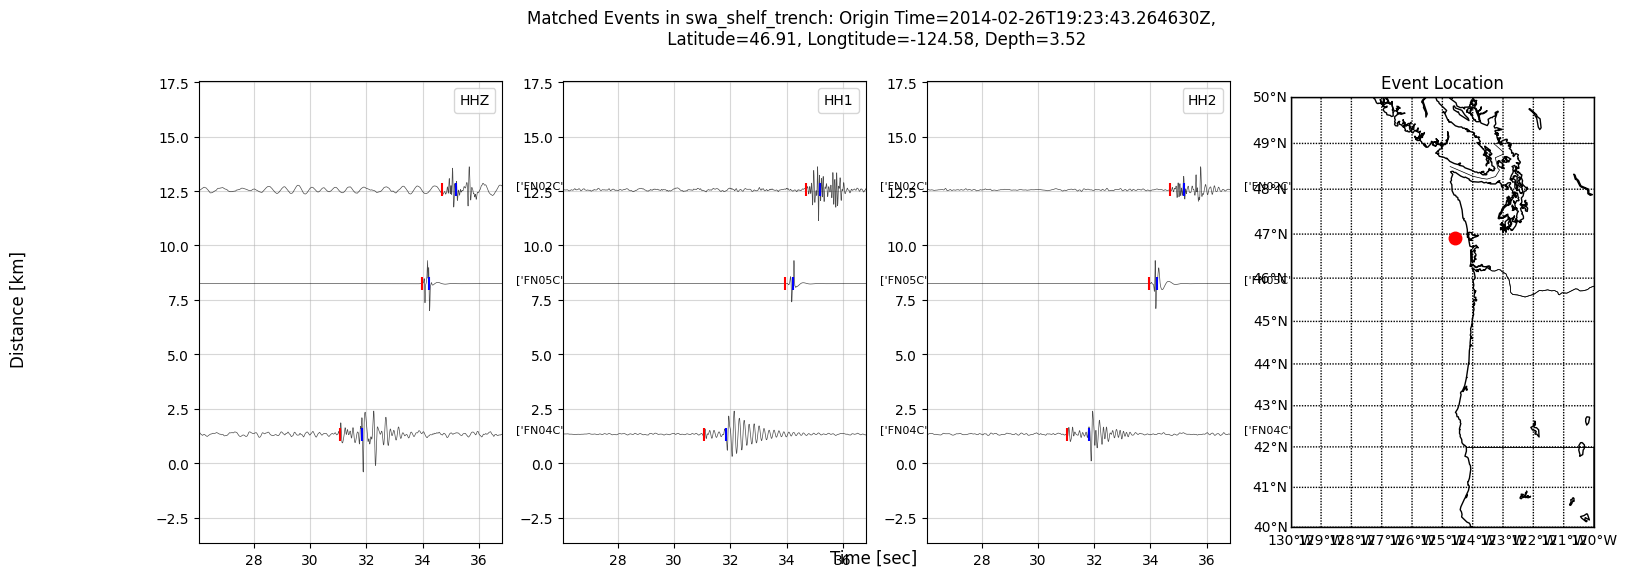

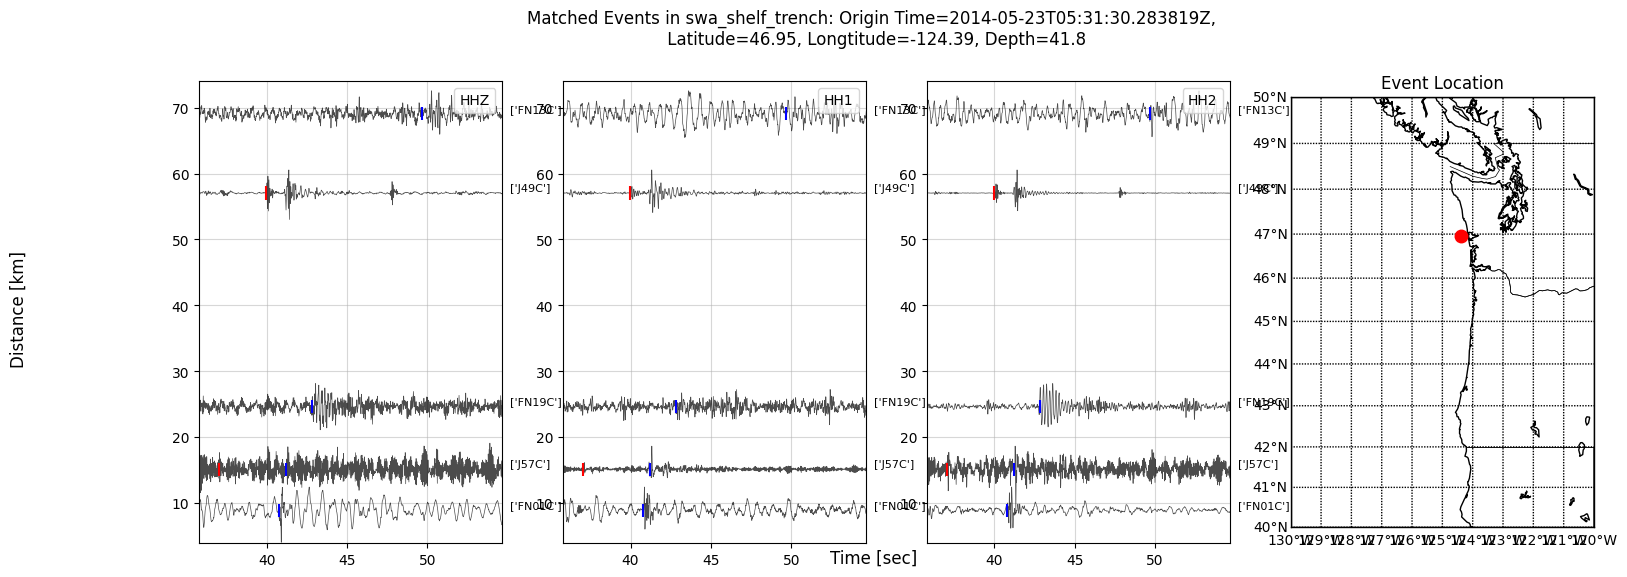

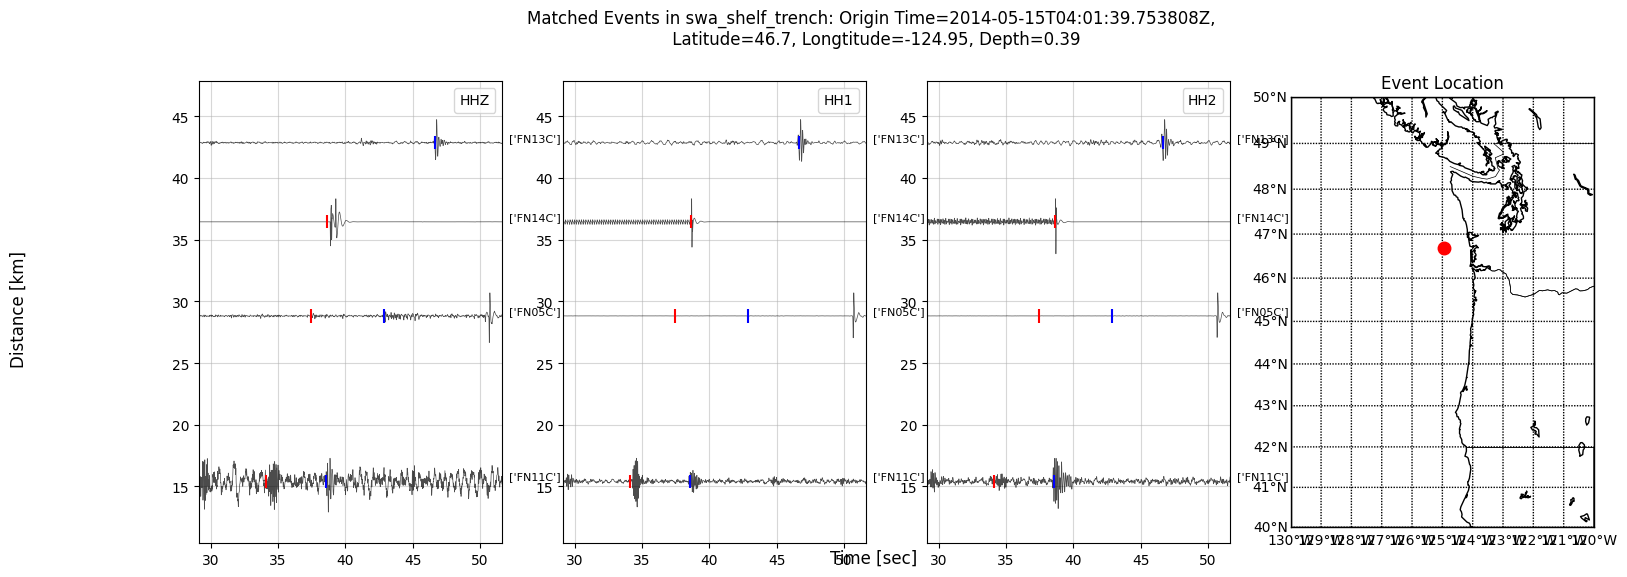

In [7]:
subplots_cluster_scale_rand(mycatalog, mycatalog_picks, networks, '?H?', f'Matched Events in {year}', f'plots_{year}.pdf')

In [8]:
year = 'swa_shore'
mycatalog = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/new_events_filtered_{year}.csv',index_col=0)
mycatalog_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_pick_assignments_{year}.csv',index_col=0)
networks = pd.read_csv('/home/hbito/cascadia_obs_ensemble/data/networks.csv')

100%|██████████| 3/3 [00:27<00:00,  9.06s/it]


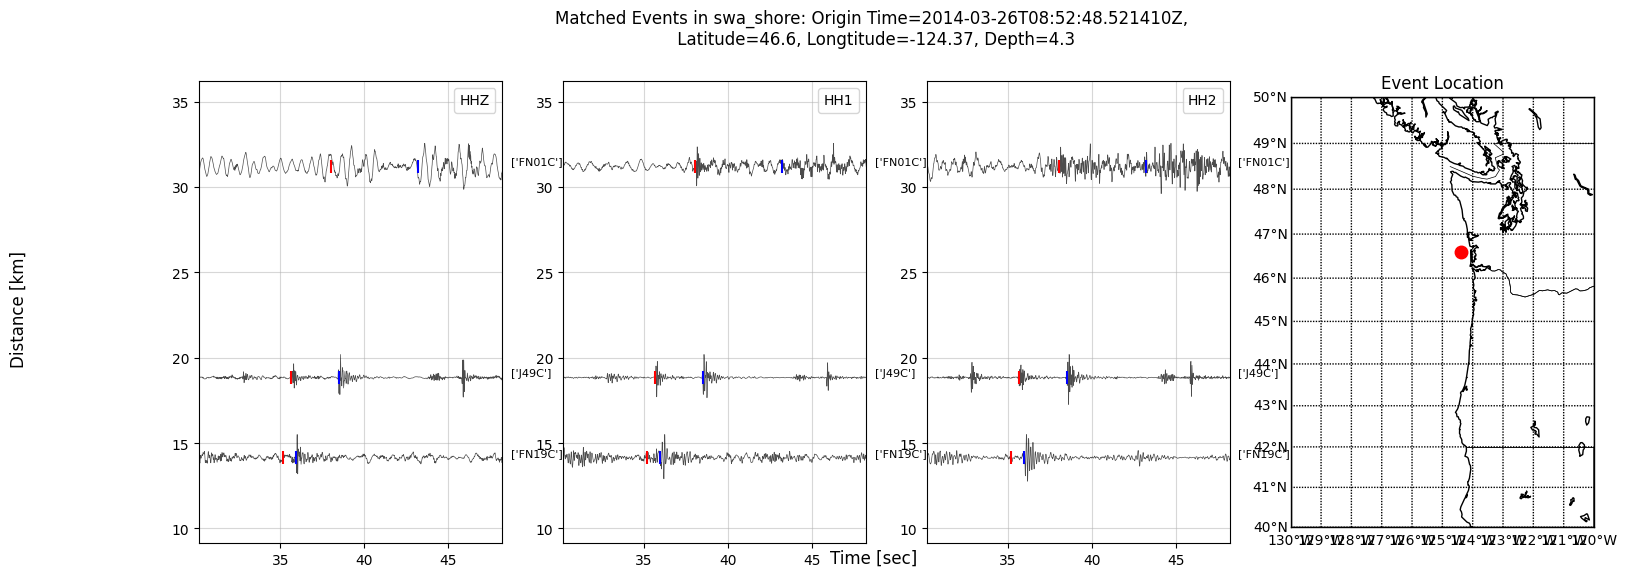

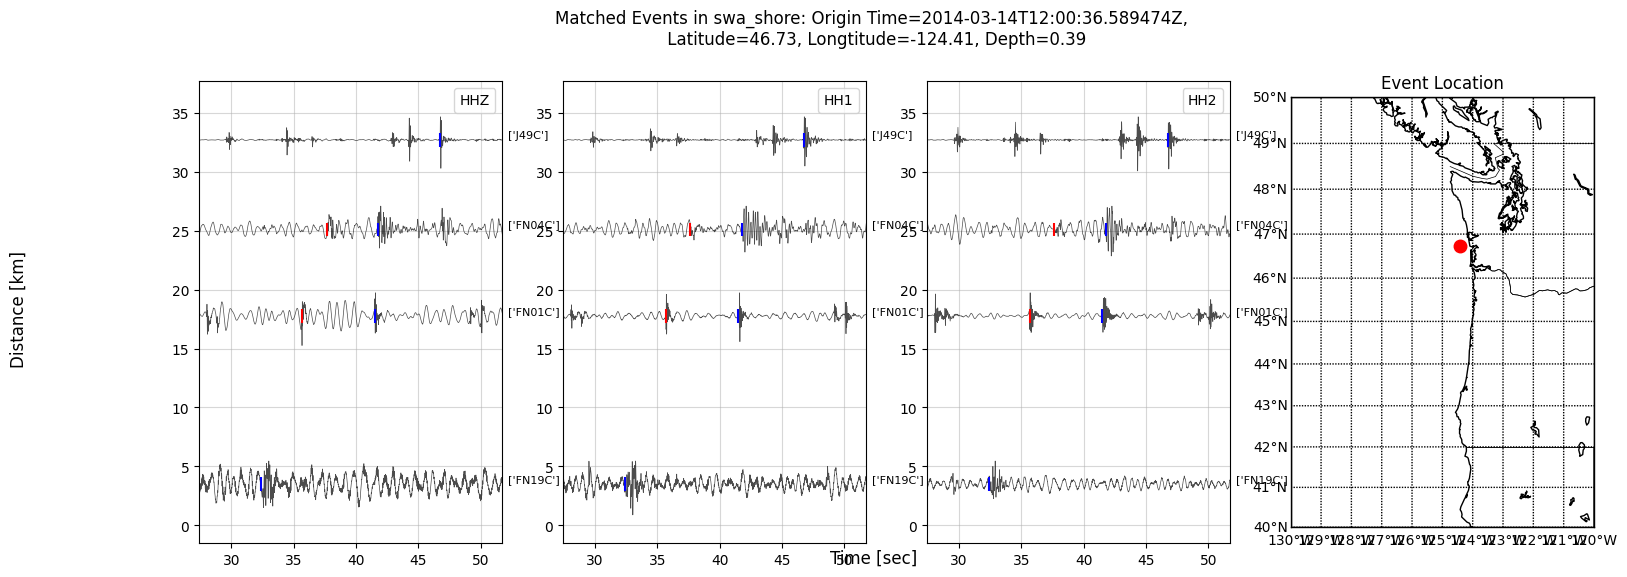

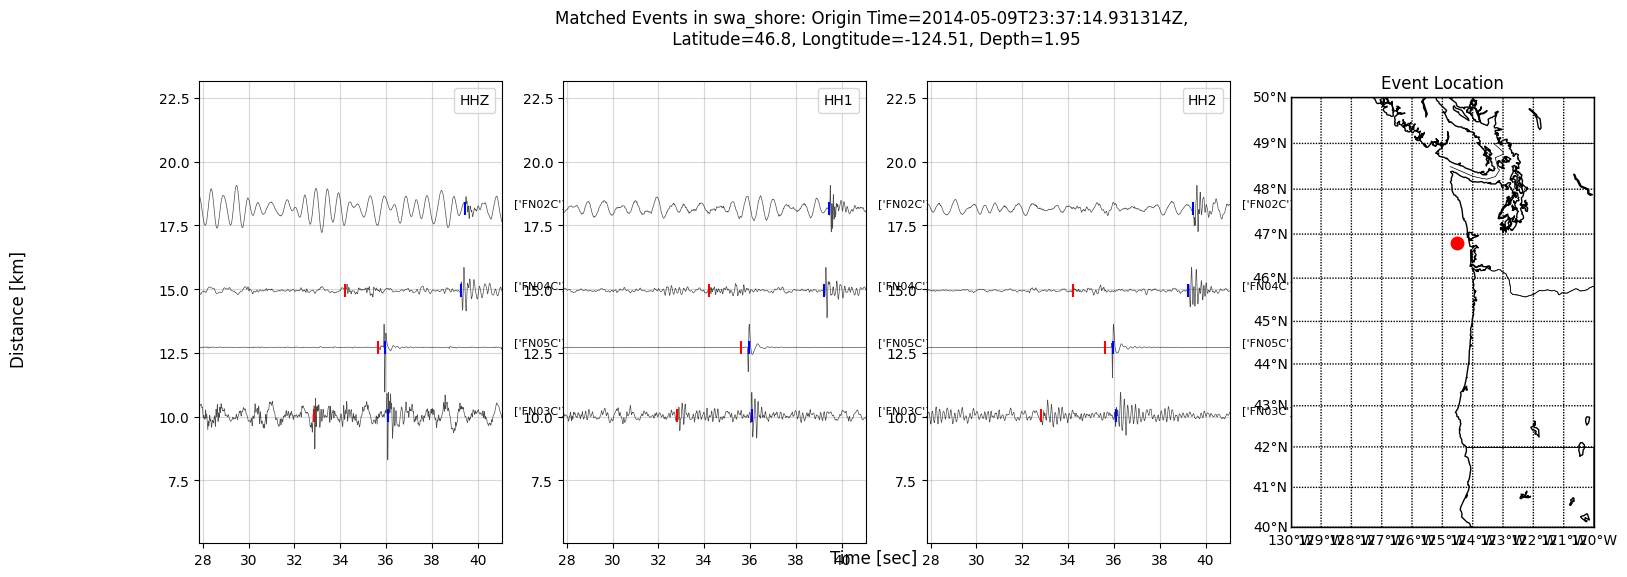

In [9]:
subplots_cluster_scale_rand(mycatalog, mycatalog_picks, networks, '?H?', f'Matched Events in {year}', f'plots_{year}.pdf')

In [9]:
year = 'pnsn_nor'
mycatalog = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/new_events_filtered_{year}.csv',index_col=0)
mycatalog_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_pick_assignments_{year}.csv',index_col=0)
networks = pd.read_csv('/home/hbito/cascadia_obs_ensemble/data/networks.csv')

  0%|          | 0/3 [00:00<?, ?it/s]/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
 33%|███▎      | 1/3 [00:02<00:05,  2.88s/it]/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
 67%|██████▋   | 2/3 [00:07<00:03,  4.00s/it]/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
100%|██████████| 3/3 [00:10<00:00,  3.48s/it]


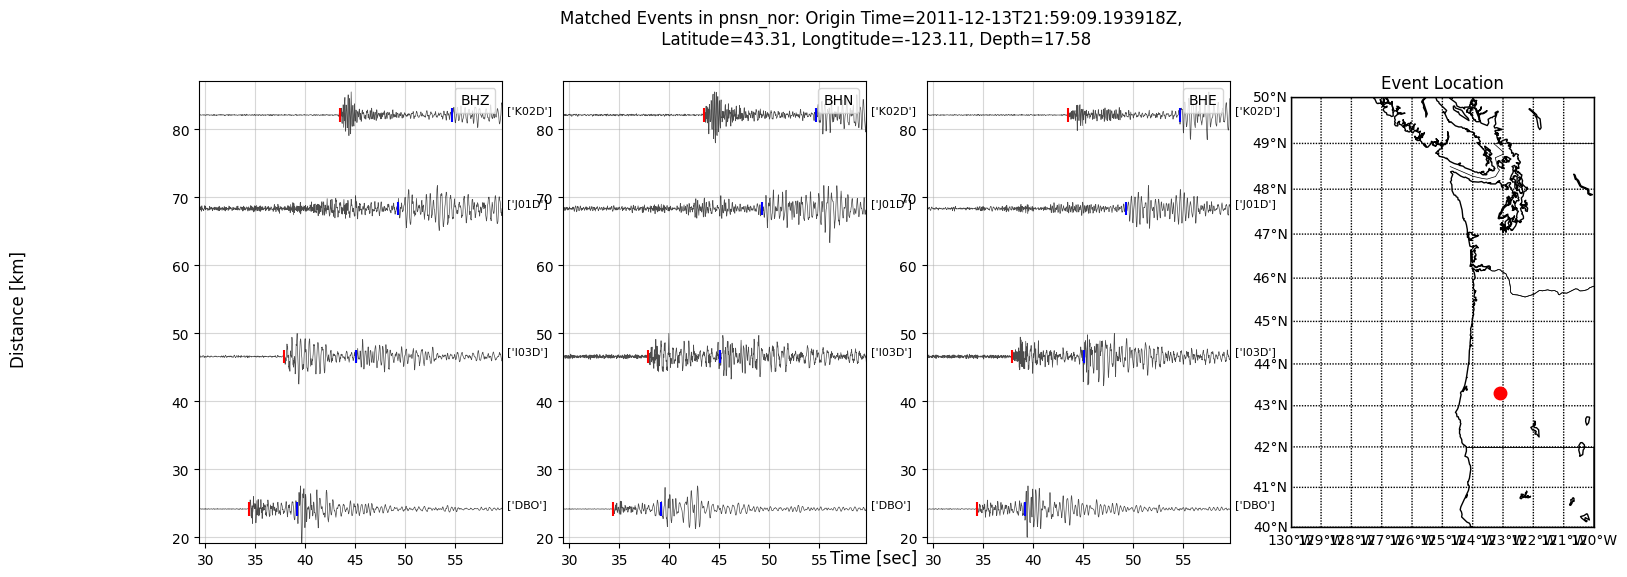

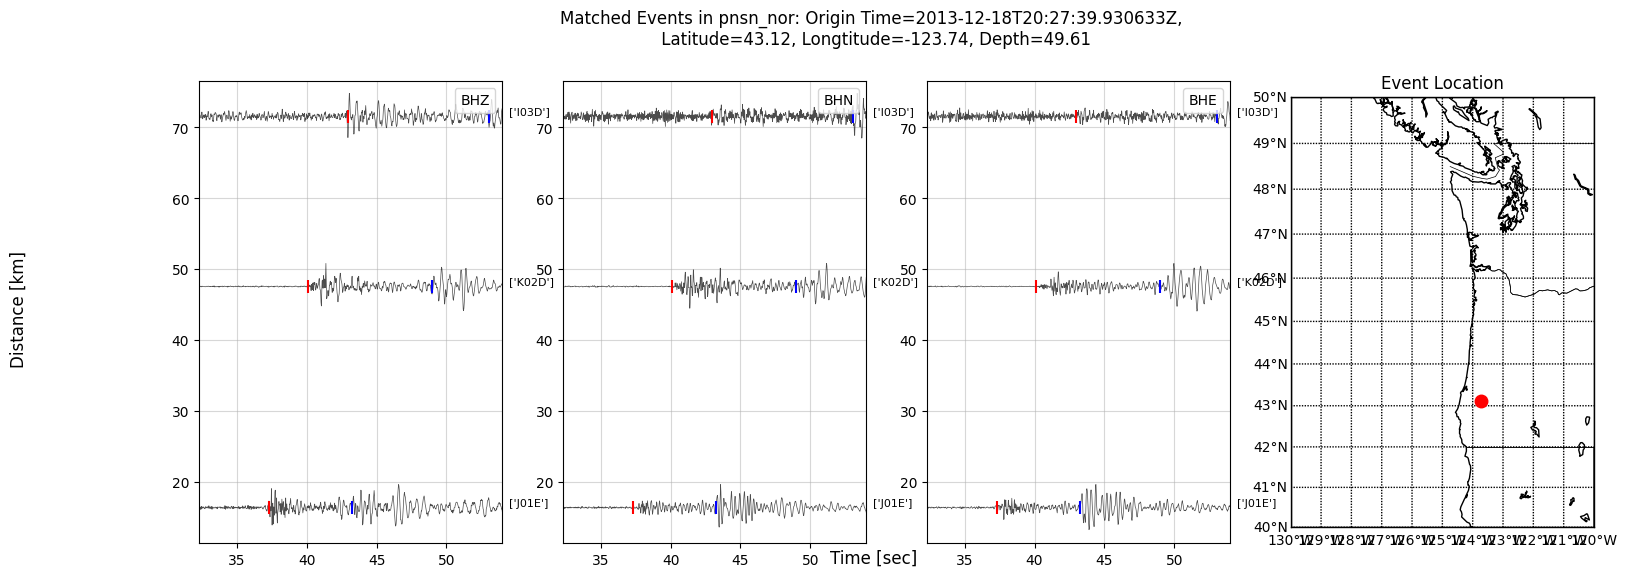

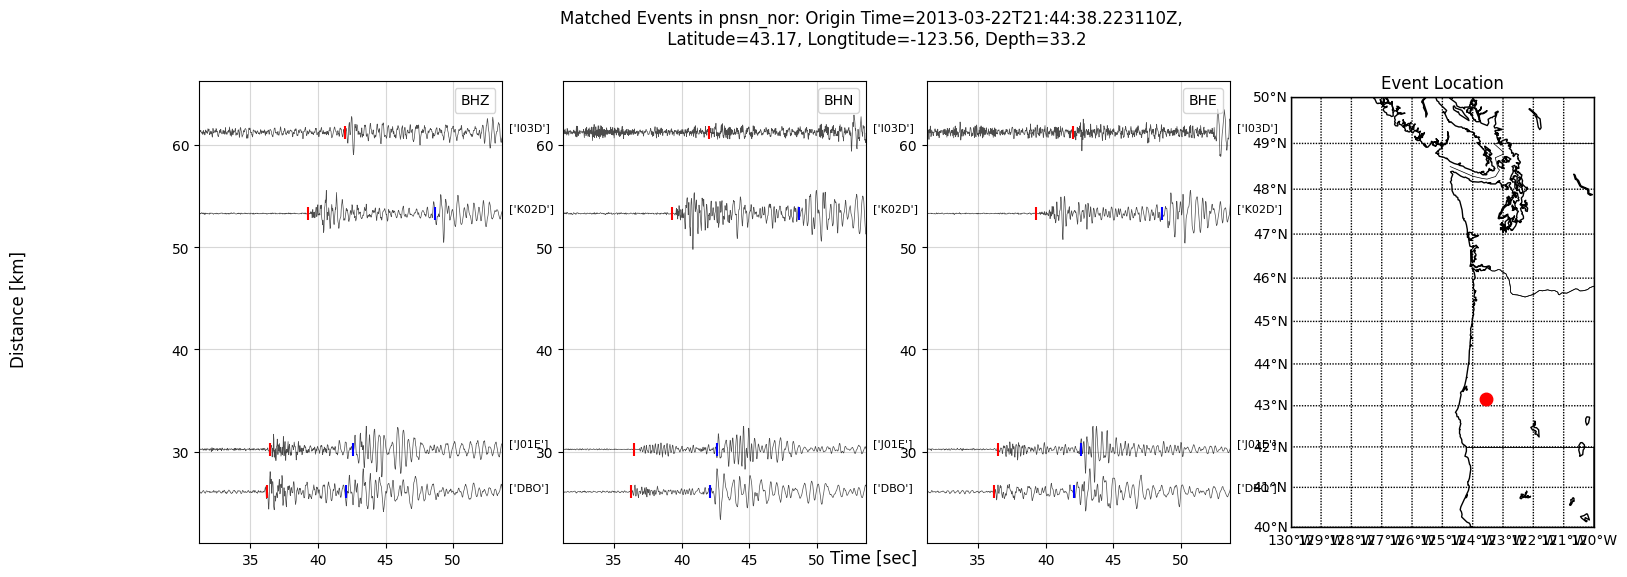

In [10]:
subplots_cluster_scale_rand(mycatalog, mycatalog_picks, networks, '?H?', f'Matched Events in {year}', f'plots_{year}.pdf')

#### Plot the events in the merged catalog 

In [4]:
mycatalog_merged = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_all_regions/merged_new_events.csv',index_col=0)
networks = pd.read_csv('/home/hbito/cascadia_obs_ensemble/data/networks.csv')

# Load all event data into a list of DataFrames
event_files = [
    '../data/datasets_nwa_shelf_trench/all_pick_assignments_nwa_shelf_trench.csv',
    '../data/datasets_nwa_shore/all_pick_assignments_nwa_shore.csv',
    '../data/datasets_or_shelf_trench/all_pick_assignments_or_shelf_trench.csv',
    '../data/datasets_or_shore/all_pick_assignments_or_shore.csv',
    '../data/datasets_pnsn_jdf/all_pick_assignments_pnsn_jdf.csv',
    '../data/datasets_pnsn_nor/all_pick_assignments_pnsn_nor.csv',
    '../data/datasets_pnsn_sor/all_pick_assignments_pnsn_sor.csv',
    '../data/datasets_pnsn_wa/all_pick_assignments_pnsn_wa.csv',
    '../data/datasets_swa_shelf_trench/all_pick_assignments_swa_shelf_trench.csv',
    '../data/datasets_swa_shore/all_pick_assignments_swa_shore.csv'
]

# Read all event files into DataFrames
dfs = [pd.read_csv(file, index_col=0) for file in event_files]

# Concatenate all DataFrames into a single DataFrame
mycatalog_picks_merged = pd.concat(dfs)

  0%|          | 0/3 [00:00<?, ?it/s]/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
 67%|██████▋   | 2/3 [00:10<00:05,  5.01s/it]/home/jupyter_share/miniconda3/envs/seismo/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
100%|██████████| 3/3 [00:14<00:00,  4.74s/it]


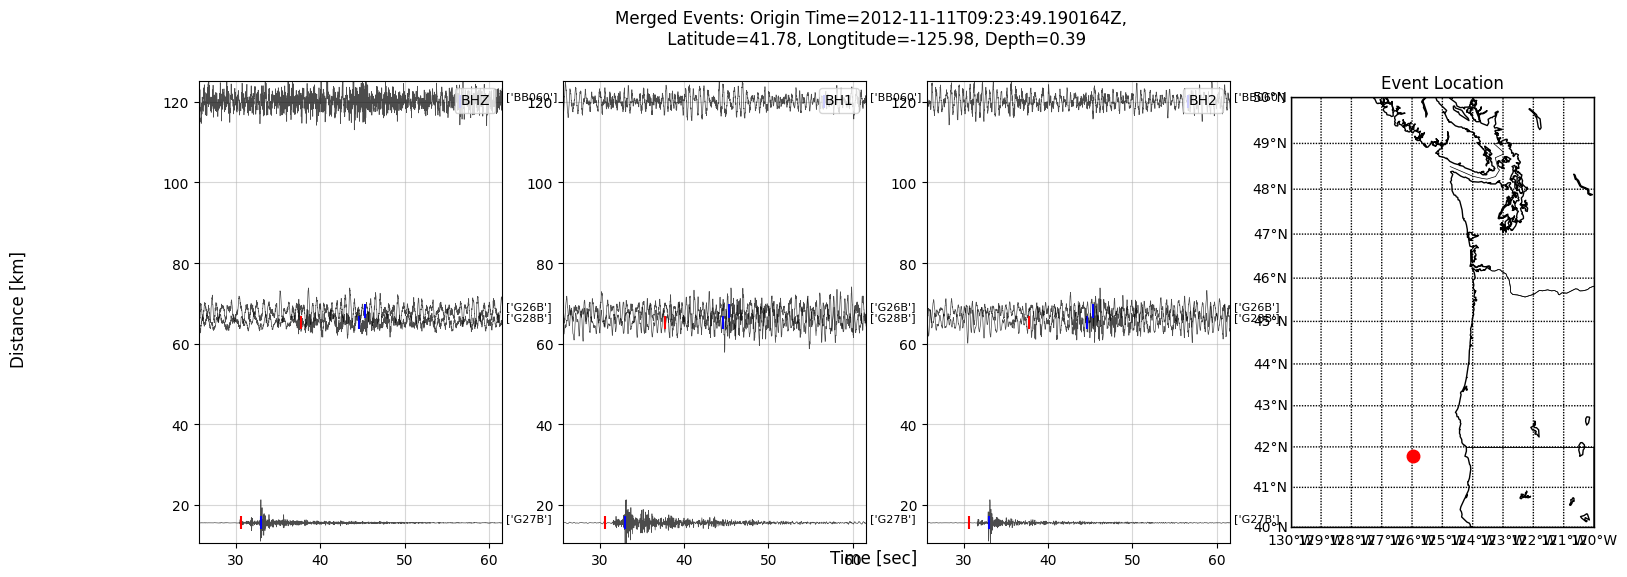

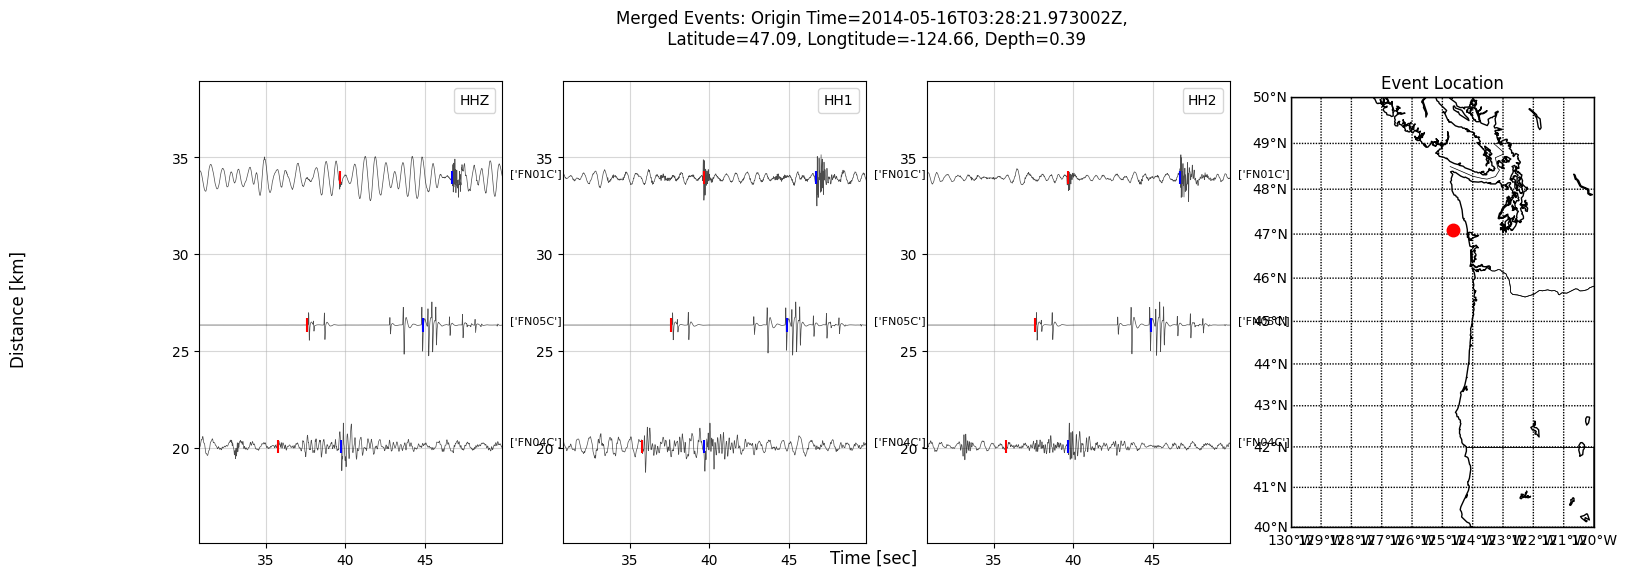

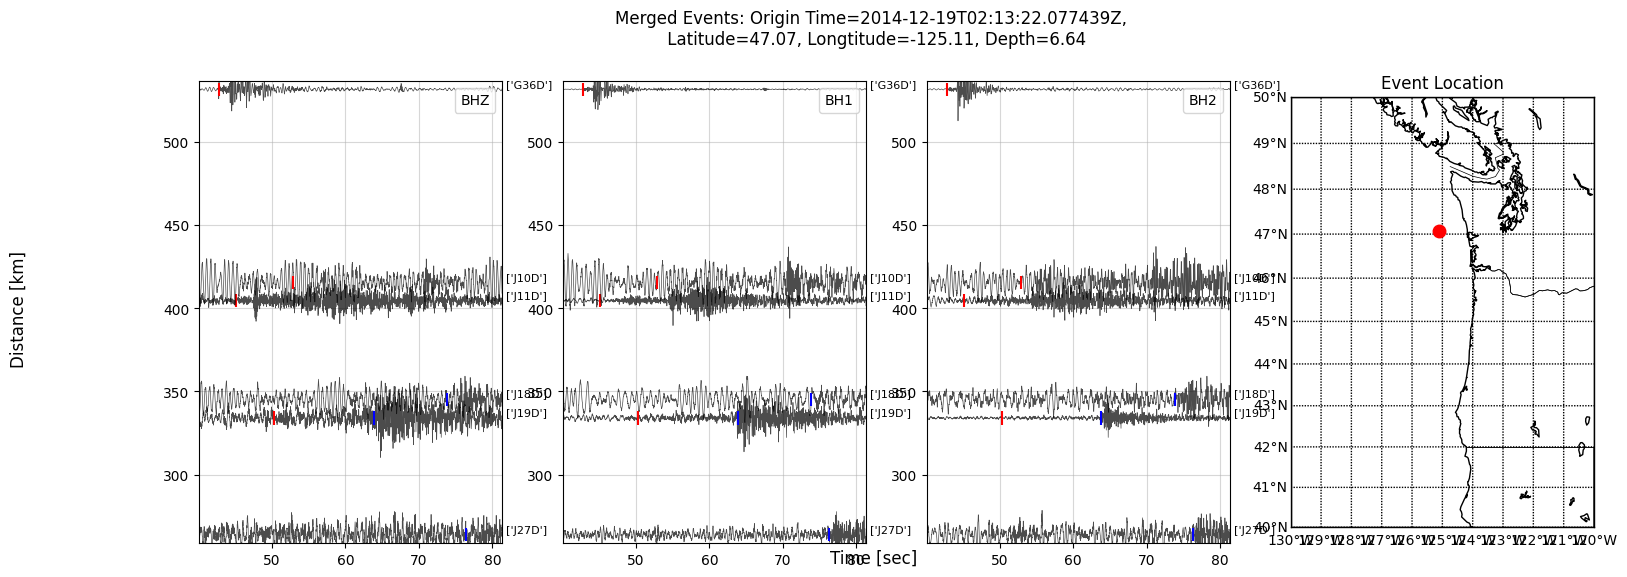

In [5]:
subplots_cluster_scale_rand(mycatalog_merged, mycatalog_picks_merged, networks, '?H?', 'Merged Events', 'merged_events.pdf')